In [1]:
# from pathlib import Path
import ipyrad.analysis as ipa
import pandas as pd
import toyplot
import toyplot.pdf

# Introduction

This document generates the PCA figures for each of the three species.
Refer to the `06-vcf2hdf5.ipynb` for the code that builds the `.hdf5` objects we
use here. Note that I'm using the *UNFILTERED* files we created, as we'll apply
filters in this script.

All result files are saved in the `results/ipyrad/population-structure/pca`
directory.

## Before we start: removing samples/populations

The population data is stored in what is called a `dictionary`. This is a data
structure that looks like the following:

```python
# Example of a python dictionary called 'population_dict' that stores our
# population groupings.
population_dict = {
	"PopA": [ sample_1, sample_2, sample_3 ],
	"PopB": [ sample_4, sample_5, sample_6],
	"PopN": [ ... ]
}
```

In the example above,  our population data is stored in a dictionary called
`population_dict`. The population identifiers are the `keys` (e.g. "PopA") and
the samples belonging to each population are the values (e.g. 
[ sample_1, sample_2, sample_3 ]).

### Removing a sample

To remove a single sample from a specific population, we can use the following
code:

```python
population_dict["PopA"].remove("sample_2")
```

This would return the following dictionary

```python
{
	"PopA": [ sample_1, sample_3 ],
	"PopB": [ sample_4, sample_5, sample_6],
	"PopN": [ ... ]
}
```

To remove multiple samples from the same population, we need to loop over the
individuals we want to remove:

```python
# List of samples to remove from "PopA" stored in variable "samples_remove"
samples_remove = [ "sample_1", "sample_2" ]

# Loop over each sample (for i in samples_remove) and remove them from "PopA"
[ population_dict["PopA"].remove( i ) for i in samples_remove ]
```

The code above would return the following:

```python
{
	"PopA": [ sample_3 ],
	"PopB": [ sample_4, sample_5, sample_6],
	"PopN": [ ... ]
}
```

To remove samples from any other population, simply repeat the process above, but
change the population you access in the code. E.g.

```python
# Lists of samples that are to be removed from each population
samples_remove_popA = [ "sample_1", "sample_2" ]
samples_remove_popB = [ "sample_6" ]

# Remove the samples - first from "PopA" then from "PopB"
[ population_dict["PopA"].remove( i ) for i in samples_remove_popA ]
[ population_dict["PopB"].remove( i ) for i in samples_remove_popB ]
```

This would return the following dictionary:

```python
{
	"PopA": [ sample_3 ],
	"PopB": [ sample_4, sample_5],
	"PopN": [ ... ]
}
```

### Removing whole populations

Alternatively, you may wish to remove all samples belonging to a population. This
can be accomplished by removing the `key` that the samples belong to. Using the
same example dictionary as above, we could remove `PopB` by running the following
code:


```python
population_dict.pop("PopB")
```

Which would return the following dictionary

```python
population_dict = {
	"PopA": [ sample_1, sample_2, sample_3 ],
	"PopN": [ ... ]
}
```

The `key` "PopB" has been removed entirely, along with all of the samples that
belonged to it.

# Problem samples

We had numerous samples that had low read counts/assignment issues. We load them
here and use them to filter our data.

In [2]:
problems = pd.read_csv(
    "../data/popmaps/dropped-samples.tsv",
    sep = "\t",
    comment="#",
    names = ["sample", "population"]
)

problems = dict(problems.groupby("population")["sample"].apply(list))

# Accessory function for dropping samples
def drop_samples(probs: dict, pop_dict: dict) -> dict:
    for k,v in probs.items():
        if k in pop_dict.keys():
            for sample in v:
                if sample in pop_dict[k]:
                    print(f"Dropping: {sample}")
                    pop_dict[k].remove(sample)
    return pop_dict

## *Aipysurus laevis*

Below, we specify the path to the `.hdf5` file we created for *Aipysurus*.
We then read the the population-map file in and turn it into a dictionary
(the type of object required by the software). I remove one sample which appears
to be a significant outlier, before setting max missing at 50%. This shouldn't
have much of an impact, but we set it anyway.

In [3]:
# Unfiltered HDF5 file we created in the previous ipynb file
ala_50kb_LD = "../results/ipyrad/ALA-stringent_outfiles/ALA-stringent.LD50k.snps.hdf5"

# Read the A. laevis population file as a Pandas dataframe
populations = pd.read_csv(
    "../data/popmaps/ALA-popmap.txt",
    comment="#", 
    sep=" ", 
    names=["sample", "grouping"]
)

# Convert the Pandas data frame to a dictionary
imap = dict(populations.groupby("grouping")["sample"].apply(list))

# Remove samples based on problems dict
imap = drop_samples(probs=problems, pop_dict=imap)

# 50% of samples with data in each group
minmap = {i: 0.5 for i in imap}

Dropping: ALA-AL401-3991432
Dropping: ALA-AL404-3991435


Next we generate a `pca` object. This object takes all the data we've specified
above and runs the PCA analysis. Note that we've left the `minmap` variable
at a 50% threshold. This is so the imputation software can do its thing.

In [4]:
pca = ipa.pca(
    data=ala_50kb_LD,
    imap=imap,
    minmap=minmap,
    mincov=0.75,
    impute_method="sample",
)
pca.run()

Samples: 203
Sites before filtering: 133969
Filtered (indels): 0
Filtered (bi-allel): 2640
Filtered (mincov): 94420
Filtered (minmap): 105552
Filtered (subsample invariant): 17420
Filtered (minor allele frequency): 0
Filtered (combined): 112751
Sites after filtering: 21275
Sites containing missing values: 20802 (97.78%)
Missing values in SNP matrix: 278478 (6.45%)
SNPs (total): 21275
SNPs (unlinked): 6303
Imputation: 'sampled'; (0, 1, 2) = 92.9%, 4.5%, 2.6%
Subsampling SNPs: 6303/21275


Below I save the principal component values as a dataframe so we can plot the
data in `R` later on. I also save the variance components as a single column
table.

In [5]:
# store the PC axes as a dataframe
df = pd.DataFrame(pca.pcaxes[0], index=pca.names)
df_variance = pd.DataFrame(pca.variances[0])

# write the PC axes to a CSV file
df.to_csv("../results/population-structure/pca/ALA-stringent_pca.csv")
df_variance.to_csv("../results/population-structure/pca/ALA-stringent_pca-variance.csv")

Lastly, we generate the figure. The `pca.draw()` method is key here. The stuff
after is some minor formatting - setting the background to white and ensuring
the legends don't get cut off to the right of screen. We then save the figure to
the output directory. This is repeated for the PC1 vs PC3 and PC2 vs PC3 comparisons.

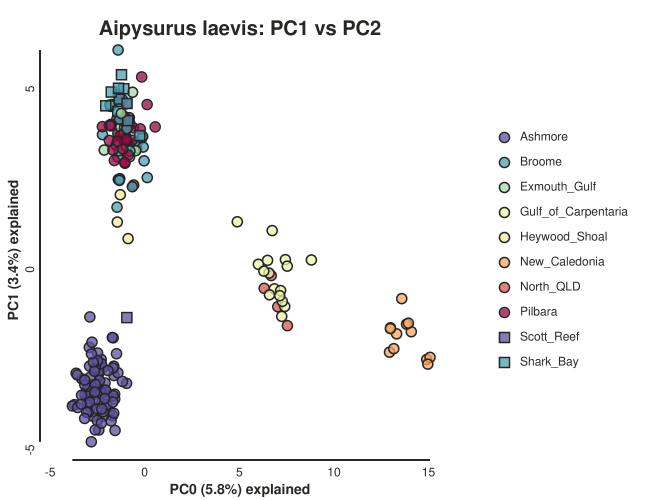

In [6]:
# Draw and save 'figure object' to variable figure
figure, _ = pca.draw(
    0, 1,
    width=600, height=500,
    label = "Aipysurus laevis: PC1 vs PC2"
)

# Set background colour to white
figure.style.update({"background-color": "white"})

# Increase figure width to prevent legend from being cut off
figure.width = 650

# save as PDF
toyplot.pdf.render(figure, "../results/population-structure/pca/ALA-stringent_PCA-1_2.pdf")
figure

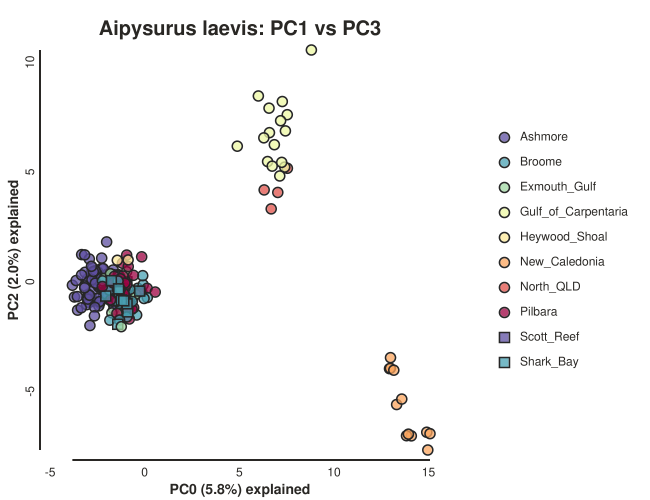

In [7]:
figure, _ = pca.draw(
    0, 2,
    width=600, height=500,
    label = "Aipysurus laevis: PC1 vs PC3"
)

# Set background colour to white
figure.style.update({"background-color": "white"})

# Increase figure width to prevent legend from being cut off
figure.width = 650

# save as PDF
toyplot.pdf.render(figure, "../results/population-structure/pca/ALA-stringent_PCA-1_3.pdf")
figure

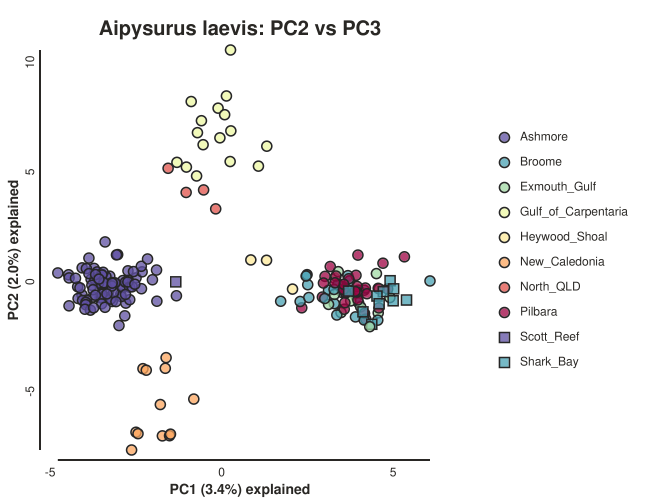

In [8]:
figure, _ = pca.draw(
    1, 2,
    width=600, height=500,
    label = "Aipysurus laevis: PC2 vs PC3"
)

# Set background colour to white
figure.style.update({"background-color": "white"})

# Increase figure width to prevent legend from being cut off
figure.width = 650

# save as PDF
toyplot.pdf.render(figure, "../results/population-structure/pca/ALA-stringent_PCA-2_3.pdf")
figure

## *Hydrophis major*

This next section repeats the same steps, but for the *Hydrophis* data.

In [9]:
data = "../results/ipyrad/HMA-stringent_outfiles/HMA-stringent.LD50k.snps.hdf5"

# Population dictionary from popmap file
populations = pd.read_csv(
    "../data/popmaps/HMA-popmap.txt",
    comment="#", 
    sep=" ", 
    names=["sample", "grouping"]
)

imap = dict(populations.groupby("grouping")["sample"].apply(list))
imap = drop_samples(probs=problems, pop_dict=imap)

# 50% of samples with data in each group
minmap = {i: 0.5 for i in imap}

In [10]:
pca = ipa.pca(
    data=data,
    imap=imap,
    minmap=minmap,
    mincov=0.75,
    impute_method="sample",
)

pca.run()

Samples: 92
Sites before filtering: 52666
Filtered (indels): 0
Filtered (bi-allel): 705
Filtered (mincov): 39299
Filtered (minmap): 41379
Filtered (subsample invariant): 46
Filtered (minor allele frequency): 0
Filtered (combined): 42294
Sites after filtering: 10383
Sites containing missing values: 10273 (98.94%)
Missing values in SNP matrix: 86632 (9.07%)
SNPs (total): 10383
SNPs (unlinked): 4324
Imputation: 'sampled'; (0, 1, 2) = 89.4%, 6.8%, 3.8%
Subsampling SNPs: 4324/10383


In [11]:
# store the PC axes as a dataframe
df = pd.DataFrame(pca.pcaxes[0], index=pca.names)
df_variance = pd.DataFrame(pca.variances[0])

# write the PC axes to a CSV file
df.to_csv("../results/population-structure/pca/HMA-stringent_pca.csv")
df_variance.to_csv("../results/population-structure/pca/HMA-stringent_pca-variance.csv")

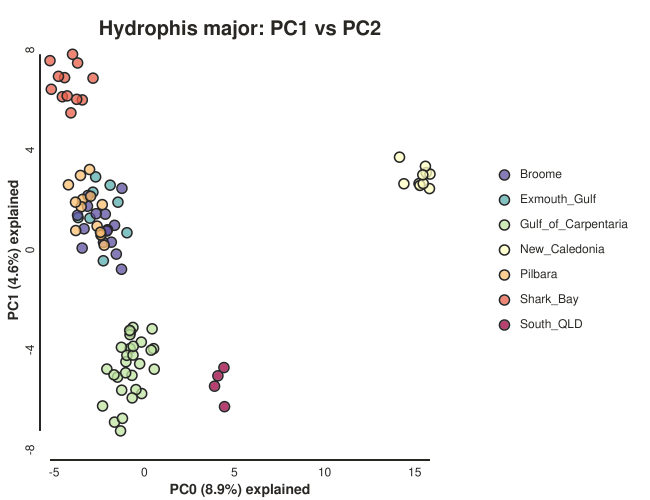

In [12]:
# Draw and save 'figure object' to variable figure
figure, _ = pca.draw(
    0, 1,
    width=600, height=500,
    label = "Hydrophis major: PC1 vs PC2"
)

# Set background colour to white
figure.style.update({"background-color": "white"})

# Increase figure width to prevent legend from being cut off
figure.width = 650

# save as PDF
toyplot.pdf.render(figure, "../results/population-structure/pca/HMA-stringent_PCA-1_2.pdf")
figure

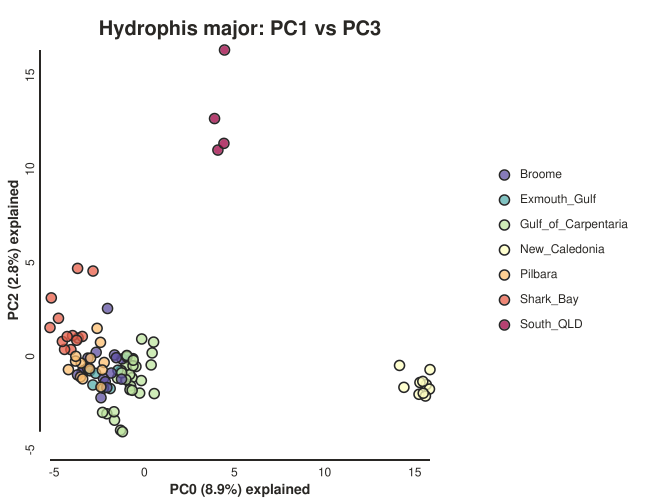

In [13]:
# Draw and save 'figure object' to variable figure
figure, _ = pca.draw(
    0, 2,
    width=600, height=500,
    label = "Hydrophis major: PC1 vs PC3"
)

# Set background colour to white
figure.style.update({"background-color": "white"})

# Increase figure width to prevent legend from being cut off
figure.width = 650

# save as PDF
toyplot.pdf.render(figure, "../results/population-structure/pca/HMA-stringent_PCA-1_3.pdf")
figure

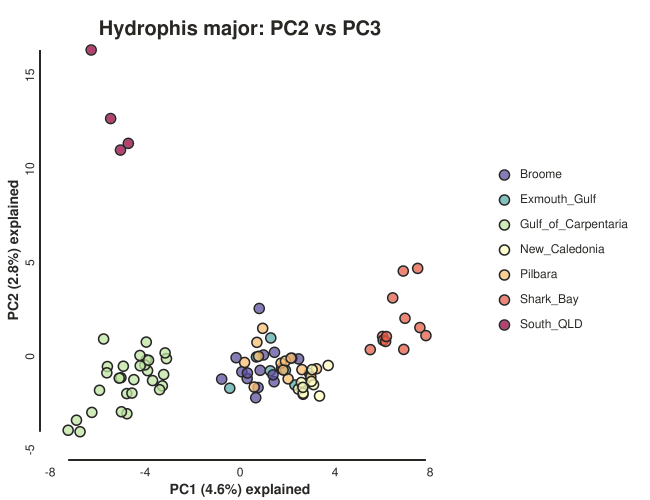

In [14]:
# Draw and save 'figure object' to variable figure
figure, _ = pca.draw(
    1, 2,
    width=600, height=500,
    label = "Hydrophis major: PC2 vs PC3"
)

# Set background colour to white
figure.style.update({"background-color": "white"})

# Increase figure width to prevent legend from being cut off
figure.width = 650

# save as PDF
toyplot.pdf.render(figure, "../results/population-structure/pca/HMA-stringent_PCA-2_3.pdf")
figure

## *Hydrophis stokesii*

And again, but for *stokesii*.

In [15]:
data = "../results/ipyrad/HST-stringent_outfiles/HST-stringent.LD50k.snps.hdf5"

# Population dictionary from popmap file
populations = pd.read_csv(
    "../data/popmaps/HST-popmap.txt",
    comment="#", 
    sep=" ", 
    names=["sample", "grouping"]
)

imap = dict(populations.groupby("grouping")["sample"].apply(list))
imap = drop_samples(probs=problems, pop_dict=imap)

# 50% of samples with data in each group
minmap = {i: 0.5 for i in imap}

Dropping: HST-KLS0360-2562274
Dropping: HST-KLS0634-2892478
Dropping: HST-KLS1679-4013420
Dropping: HST-KLS1677-4013418
Dropping: HST-KLS0660-2892454
Dropping: HST-KLS0886-2892390
Dropping: HST-KLS0941-2892545
Dropping: HST-KLS0897-2892551
Dropping: HST-KLS0896-2892403
Dropping: HST-As012-3991487
Dropping: HST-As010-3991485
Dropping: HST-KLS1204-3593361


In [16]:
pca = ipa.pca(
    data=data,
    imap=imap,
    minmap=minmap,
    mincov=0.75,
    impute_method="sample",
)

pca.run()

Samples: 102
Sites before filtering: 90080
Filtered (indels): 0
Filtered (bi-allel): 1122
Filtered (mincov): 60492
Filtered (minmap): 76533
Filtered (subsample invariant): 30785
Filtered (minor allele frequency): 0
Filtered (combined): 82680
Sites after filtering: 7115
Sites containing missing values: 5474 (76.94%)
Missing values in SNP matrix: 25816 (3.56%)
SNPs (total): 7115
SNPs (unlinked): 3449
Imputation: 'sampled'; (0, 1, 2) = 87.2%, 7.1%, 5.7%
Subsampling SNPs: 3449/7115


In [17]:
# store the PC axes as a dataframe
df = pd.DataFrame(pca.pcaxes[0], index=pca.names)
df_variance = pd.DataFrame(pca.variances[0])

# write the PC axes to a CSV file
df.to_csv("../results/population-structure/pca/HST-stringent_pca.csv")
df_variance.to_csv("../results/population-structure/pca/HST-stringent_pca-variance.csv")

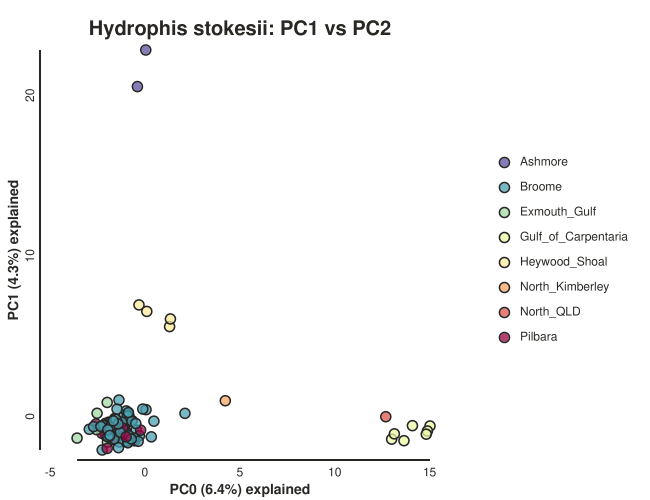

In [18]:
# Draw and save 'figure object' to variable figure
figure, _ = pca.draw(
    0, 1,
    width=600, height=500,
    label = "Hydrophis stokesii: PC1 vs PC2"
)

# Set background colour to white
figure.style.update({"background-color": "white"})

# Increase figure width to prevent legend from being cut off
figure.width = 650

# save as PDF
toyplot.pdf.render(figure, "../results/population-structure/pca/HST-stringent_PCA-1_2.pdf")
figure

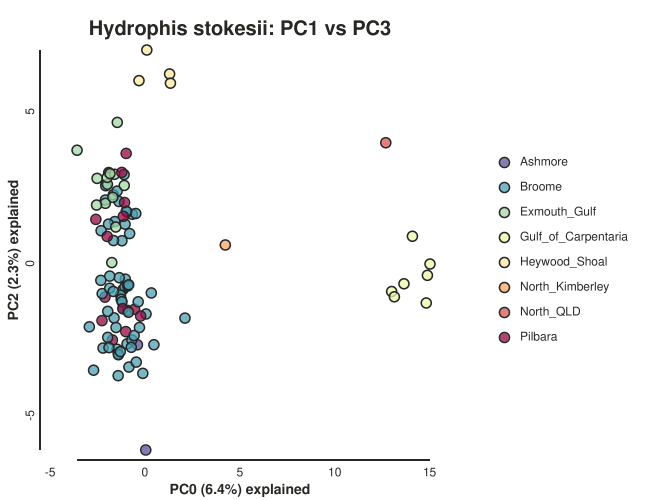

In [19]:
# Draw and save 'figure object' to variable figure
figure, _ = pca.draw(
    0, 2,
    width=600, height=500,
    label = "Hydrophis stokesii: PC1 vs PC3"
)

# Set background colour to white
figure.style.update({"background-color": "white"})

# Increase figure width to prevent legend from being cut off
figure.width = 650

# save as PDF
toyplot.pdf.render(figure, "../results/population-structure/pca/HST-stringent_PCA-1_3.pdf")
figure

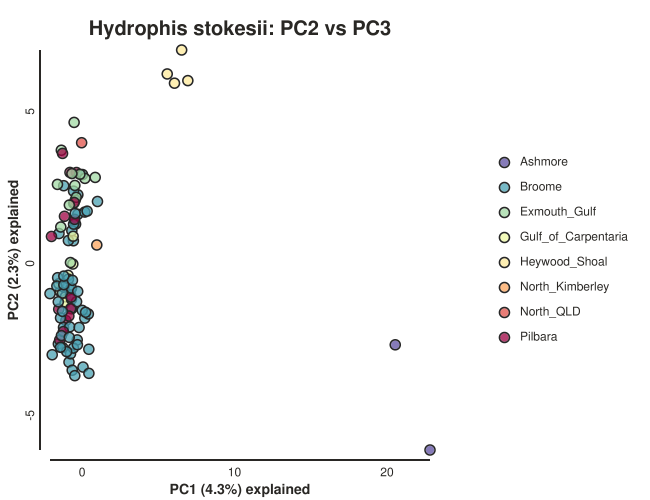

In [20]:
# Draw and save 'figure object' to variable figure
figure, _ = pca.draw(
    1, 2,
    width=600, height=500,
    label = "Hydrophis stokesii: PC2 vs PC3"
)

# Set background colour to white
figure.style.update({"background-color": "white"})

# Increase figure width to prevent legend from being cut off
figure.width = 650

# save as PDF
toyplot.pdf.render(figure, "../results/population-structure/pca/HST-stringent_PCA-2_3.pdf")
figure